/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4290 - loss: 0.7775 - val_accuracy: 0.8791 - val_loss: 0.5371
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7656 - loss: 0.5611 - val_accuracy: 0.9451 - val_loss: 0.4036
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8869 - loss: 0.4326 - val_accuracy: 0.9451 - val_loss: 0.3259
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9201 - loss: 0.3468 - val_accuracy: 0.9451 - val_loss: 0.2687
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9238 - loss: 0.2982 - val_accuracy: 0.9451 - val_loss: 0.2258
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9358 - loss: 0.2516 - val_accuracy: 0.9451 - val_loss: 0.1933
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9687 - loss: 0.2008 - val_accuracy: 0.9560 - val_loss: 0.1696
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9564 - loss: 0.1750 - val_accuracy: 0.9

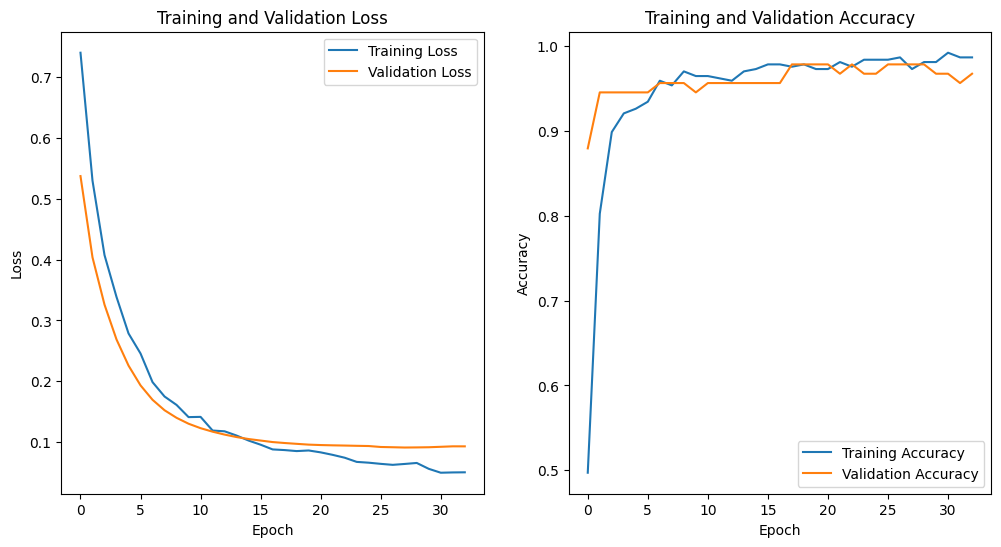

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load breast cancer dataset
data = load_breast_cancer()

# Features and labels
X = data.data
y = data.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model creation
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model training with early stopping
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Model evaluation
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Predictions
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Additional evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions_binary))
print("\nClassification Report:")
print(classification_report(y_test, predictions_binary))

# Example of classifying a single example
example_idx = 0
example_features = X_test_scaled[example_idx].reshape(1, -1)
example_label = y_test[example_idx]
print("\nExample Features:")
print(example_features)
print("Example True Label:", example_label)
predicted_label = model.predict(example_features)
print("Predicted Label:", np.round(predicted_label[0][0]))

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

# Load data
data = load_breast_cancer()

# Separate features and target variable
X = data.data
y = data.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model creation function accepting dynamic parameters
def create_model(dense_units=64, dropout_rate=0.2, meta=None):
    model = Sequential()
    # Specify the input shape explicitly with an Input layer
    model.add(Input(shape=(meta["n_features_in_"],) if meta else (X_scaled.shape[1],)))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, model__dense_units=64, model__dropout_rate=0.2, epochs=100, batch_size=32, verbose=0)

# Define K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define grid search parameters
param_grid = {
    'model__dense_units': [64, 128, 256],
    'model__dropout_rate': [0.2, 0.3, 0.5]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, verbose=2)
grid_result = grid_search.fit(X_scaled, y)

# Print best parameters and accuracy
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy found: ", grid_result.best_score_)

# Evaluate using the best parameters found
best_params = {k.replace("model__", ""): v for k, v in grid_result.best_params_.items()}
final_model = create_model(**best_params)
final_model.fit(X_scaled, y, epochs=100, batch_size=32)

_, accuracy = final_model.evaluate(X_scaled, y)
print("Final model accuracy: {:.2f}%".format(accuracy * 100))


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END .....model__dense_units=64, model__dropout_rate=0.2; total time=  10.3s
[CV] END .....model__dense_units=64, model__dropout_rate=0.2; total time=   8.3s
[CV] END .....model__dense_units=64, model__dropout_rate=0.2; total time=   8.2s
[CV] END .....model__dense_units=64, model__dropout_rate=0.2; total time=   7.0s
[CV] END .....model__dense_units=64, model__dropout_rate=0.2; total time=   8.9s
[CV] END .....model__dense_units=64, model__dropout_rate=0.3; total time=   8.5s
[CV] END .....model__dense_units=64, model__dropout_rate=0.3; total time=   7.4s
[CV] END .....model__dense_units=64, model__dropout_rate=0.3; total time=   8.6s
[CV] END .....model__dense_units=64, model__dropout_rate=0.3; total time=   8.4s
[CV] END .....model__dense_units=64, model__dropout_rate=0.3; total time=   8.1s
[CV] END .....model__dense_units=64, model__dropout_rate=0.5; total time=   8.2s
[CV] END .....model__dense_units=64, model__dropout_rate=0.5; total time=   8.5s
[CV] END .....model__dense_u